In [1]:
%matplotlib inline

In [2]:
%pip install scipy
%pip install biotite

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



# Docking biotin to streptavidin

This example shows how to use *AutoDock Vina* :footcite:`Trott2010`
from within *Biotite* for docking a ligand molecule to a known receptor
structure.
As example, we examine the famous streptavidin-biotin interaction.

At first we download a high resolution structure of the complex.
The resolution is important here:
For one thing, the docking procedure requires annotated hydrogen atoms
for the receptor molecule, which seldom is the case for low resolution
X-ray structures.
On the other hand, we would like to have a reliable reference binding
mode of the ligand, to evaluate how well out docking procedure went

After separation of the receptor and the reference ligand,
a biotin model is loaded from the chemical components dictionary and
docked into the binding cavity of streptavidin.

Finally, the docked model is compared to the reference model, with
respect to their RMSD.

.. footbibliography::


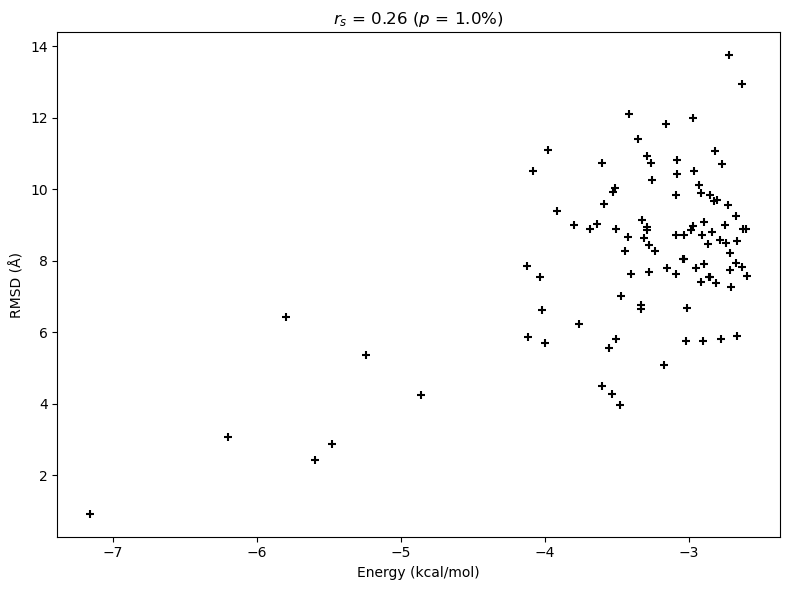

In [3]:
# Code source: Patrick Kunzmann
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import biotite.structure as struc
import biotite.structure.info as info
import biotite.structure.io.mmtf as mmtf
import biotite.structure.graphics as graphics
import biotite.database.rcsb as rcsb
import biotite.application.autodock as autodock


# Get the receptor structure
# and the original 'correct' conformation of the ligand
mmtf_file = mmtf.MMTFFile.read(rcsb.fetch("2RTG", "mmtf"))
structure = mmtf.get_structure(
    # Include formal charge for accurate partial charge calculation
    mmtf_file, model=1, include_bonds=True, extra_fields=["charge"]
)
# The asymmetric unit describes a streptavidin homodimer
# However, we are only interested in a single monomer
structure = structure[structure.chain_id == "B"]
receptor = structure[struc.filter_amino_acids(structure)]

ref_ligand = structure[structure.res_name == "BTN"]
ref_ligand_center = struc.centroid(ref_ligand)


# Independently, get the ligand without optimized conformation
# from the chemical components dictionary
ligand = info.residue("BTN")

# Search for a binding mode in a 20 Å radius
# of the original ligand position
app = autodock.VinaApp(ligand, receptor, ref_ligand_center, [20, 20, 20], bin_path="/Users/vt/vina")
# For reproducibility
app.set_seed(0)
# This is the maximum number:
# Vina may find less interesting binding modes
# and thus output less models
app.set_max_number_of_models(100)
# Effectively no limit
app.set_energy_range(100.0)
# Start docking run
app.start()
app.join()
docked_coord = app.get_ligand_coord()
energies = app.get_energies()

# Create an AtomArrayStack for all docked binding modes
docked_ligand = struc.from_template(ligand, docked_coord)
# As Vina discards all nonpolar hydrogen atoms, their respective
# coordinates are NaN -> remove these atoms
docked_ligand = docked_ligand[
    ..., ~np.isnan(docked_ligand.coord[0]).any(axis=-1)
]

# For comparison of the docked pose with the experimentally determined
# reference conformation, the atom order of both must be exactly the
# same
# Therefore, all atoms, that are additional in one of both models,
# e.g. carboxy or nonpolar hydrogen atoms, are removed...
docked_ligand = docked_ligand[
    ..., np.isin(docked_ligand.atom_name, ref_ligand.atom_name)
]
docked_ligand = docked_ligand[..., info.standardize_order(docked_ligand)]
# ...and the atom order is standardized
ref_ligand = ref_ligand[np.isin(ref_ligand.atom_name, docked_ligand.atom_name)]
ref_ligand = ref_ligand[info.standardize_order(ref_ligand)]

# Calculate the RMSD of the docked models to the correct binding mode
# No superimposition prior to RMSD calculation, as we want to see 
# conformation differences with respect to the binding pocket
rmsd = struc.rmsd(ref_ligand, docked_ligand)

# Evaluate correlation between RMSD and binding energies 
correlation, p_value = spearmanr(energies, rmsd)

figure, ax = plt.subplots(figsize=(8.0, 6.0))
ax.set_title(f"$r_s$ = {correlation:.2f} ($p$ = {p_value*100:.1f}%)")
ax.scatter(energies, rmsd, marker="+", color="black")
ax.set_xlabel("Energy (kcal/mol)")
ax.set_ylabel("RMSD (Å)")
figure.tight_layout()
plt.show()

For this specific case *AutoDock Vina* shows only a low Spearman
correlation between the RMSD of the calculated models to the
correct binding mode and the associated calculated binding energy.
A high correlation is desireable to ensure that docking results with
good binding energies correspond to the correct binding mode for cases
in which the correct binding conformation is unknown.
However, at least the calculated model with highest predicted affinity
is also the conformation with the lowest deviation from the
experimental result in this instance.
Hence, *AutoDock Vina* was able to predict an almost correct
binding mode as its best *guess*.

In a final step, we want to visually compare the experimentally
determined conformation of biotin in the binding pocket with the
minimum-energy docked conformation, which is also the conformation
with the lowest RMSD in this case.
The docked conformation is shown as ball-and-stick model, the original
experimentally determined biotin conformation is shown in transparent
blue. 



In [4]:
# Need to install ammolite using the folowing command
# 
# conda install -c conda-forge ammolite
# reference: https://ammolite.biotite-python.org/install.html

# Need to also install sphinx-gallery
# %pip install sphinx-gallery


In [5]:
# Get the best fitting model,
# i.e the model with the lowest RMSD to the reference conformation
docked_ligand = docked_ligand[np.argmin(rmsd)]

# Vina only keeps polar hydrogens in the modeled structure
# For consistency, remove all hydrogen atoms in the reference and
# modelled structure
ref_ligand = ref_ligand[ref_ligand.element!= "H"]
docked_ligand = docked_ligand[docked_ligand.element!= "H"]

sphinx_gallery_thumbnail_number = 2
# Visualization with PyMOL...

 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Ray: render time: 0.02 sec. = 191805.4 frames/hour (0.02 sec. accum.).


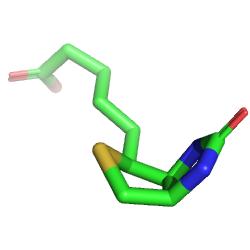

In [6]:
import ammolite
PNG_SIZE = (250,250)
# Fetch and load cytochrome C structure and remove water 
#mmtf_file = mmtf.MMTFFile.read(rcsb.fetch("2RTG", "mmtf"))
#structure = mmtf.get_structure(mmtf_file, model=1, include_bonds=True)
#cyt_c = structure[structure.res_name != "HOH"]

pymol_docked_ligand = ammolite.PyMOLObject.from_structure(docked_ligand)
ammolite.show(PNG_SIZE)

In [7]:
import nglview
view = nglview.show_pdbid("2RTG")  # load "3pqr" from RCSB PDB and display viewer widget
view

NGLWidget()

In [8]:
print(docked_ligand)

HET         0  BTN C11    C        29.536   14.438   -9.229
HET         0  BTN O11    O        28.415   14.255   -8.816
HET         0  BTN O12    O        29.887   13.985  -10.443
HET         0  BTN C10    C        30.538   15.180   -8.383
HET         0  BTN C9     C        31.843   14.386   -8.320
HET         0  BTN C8     C        31.723   13.288   -7.261
HET         0  BTN C7     C        32.880   12.301   -7.416
HET         0  BTN C2     C        32.696   11.140   -6.436
HET         0  BTN S1     S        31.825   11.704   -4.917
HET         0  BTN C6     C        32.566   10.418   -3.829
HET         0  BTN C5     C        33.983   10.255   -4.413
HET         0  BTN N1     N        34.896   11.191   -3.739
HET         0  BTN C3     C        35.426   12.017   -4.650
HET         0  BTN O3     O        36.219   12.895   -4.368
HET         0  BTN N2     N        35.004   11.790   -5.901
HET         0  BTN C4     C        34.056   10.664   -5.890


In [10]:
print(ref_ligand)

HET B     300  BTN C11    C        29.269   14.283   -9.535
HET B     300  BTN O11    O        29.975   13.789  -10.425
HET B     300  BTN O12    O        28.066   14.116   -9.443
HET B     300  BTN C10    C        29.910   15.186   -8.474
HET B     300  BTN C9     C        31.345   14.783   -8.145
HET B     300  BTN C8     C        31.333   13.417   -7.457
HET B     300  BTN C7     C        32.778   13.082   -6.989
HET B     300  BTN C2     C        32.748   11.752   -6.133
HET B     300  BTN S1     S        32.028   11.894   -4.508
HET B     300  BTN C6     C        32.768   10.303   -4.074
HET B     300  BTN C5     C        34.102   10.126   -4.775
HET B     300  BTN N1     N        35.096   10.701   -3.895
HET B     300  BTN C3     C        35.685   11.776   -4.428
HET B     300  BTN O3     O        36.571   12.417   -3.888
HET B     300  BTN N2     N        35.172   12.053   -5.619
HET B     300  BTN C4     C        34.151   11.078   -6.014


In [13]:
app.get_ligand_models()

stack([
	array([
	Atom(np.array([29.536, 14.438, -9.229], dtype=float32), chain_id="", res_id=0, ins_code="", res_name="BTN", hetero=True, atom_name="C11", element="C"),
	Atom(np.array([28.415, 14.255, -8.816], dtype=float32), chain_id="", res_id=0, ins_code="", res_name="BTN", hetero=True, atom_name="O11", element="O"),
	Atom(np.array([ 29.887,  13.985, -10.443], dtype=float32), chain_id="", res_id=0, ins_code="", res_name="BTN", hetero=True, atom_name="O12", element="O"),
	Atom(np.array([30.538, 15.18 , -8.383], dtype=float32), chain_id="", res_id=0, ins_code="", res_name="BTN", hetero=True, atom_name="C10", element="C"),
	Atom(np.array([31.843, 14.386, -8.32 ], dtype=float32), chain_id="", res_id=0, ins_code="", res_name="BTN", hetero=True, atom_name="C9", element="C"),
	Atom(np.array([31.723, 13.288, -7.261], dtype=float32), chain_id="", res_id=0, ins_code="", res_name="BTN", hetero=True, atom_name="C8", element="C"),
	Atom(np.array([32.88 , 12.301, -7.416], dtype=float32), chain_i